# Introduction

In 1912, the ship RMS Titanic struck an iceberg on its maiden voyage and sank, resulting in the deaths of most of its passengers and crew. 

### Further Resources and References

Manual Exploration was taken from an Udacity Project:

https://github.com/torenunez/machine-learning/blob/master/projects/titanic_survival_exploration/titanic_survival_exploration.ipynb


Pre-processing and modeling taken from francksylla's Kaggle Kernel: 

https://www.kaggle.com/francksylla/titanic/titanic-machine-learning-from-disaster


Feature importance taken from rdcsung's Kaggle Kernel:

https://www.kaggle.com/rdcsung/titanic/an-interactive-data-science-tutorial




# Setup

In [1]:
import re
import operator

import numpy as np
import pandas as pd

from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier, ExtraTreesRegressor
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot') 


In [2]:
train = pd.read_csv("input/train.csv", dtype={"Age": np.float64})
test  = pd.read_csv("input/test.csv", dtype={"Age": np.float64})

# Manual Exploration

From a sample of the RMS Titanic data, we can see the various features present for each passenger on the ship:
- **Survived**: Outcome of survival (0 = No; 1 = Yes)
- **Pclass**: Socio-economic class (1 = Upper class; 2 = Middle class; 3 = Lower class)
- **Name**: Name of passenger
- **Sex**: Sex of the passenger
- **Age**: Age of the passenger (Some entries contain `NaN`)
- **SibSp**: Number of siblings and spouses of the passenger aboard
- **Parch**: Number of parents and children of the passenger aboard
- **Ticket**: Ticket number of the passenger
- **Fare**: Fare paid by the passenger
- **Cabin** Cabin number of the passenger (Some entries contain `NaN`)
- **Embarked**: Port of embarkation of the passenger (C = Cherbourg; Q = Queenstown; S = Southampton)

Since we're interested in the outcome of survival for each passenger or crew member, we can remove the **Survived** feature from this dataset and store it as its own separate variable `outcomes`. We will use these outcomes as our prediction targets.  
Run the code cell below to remove **Survived** as a feature of the dataset and store it in `outcomes`.

In [3]:
# Peak at the top of the data
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print(train.shape)
train.describe()
train.count()

(891, 12)


/home/torenunez/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

In [5]:
pd.crosstab(train['Survived'], train['Sex'])

Sex,female,male
Survived,,
0,81,468
1,233,109


In [6]:
sex_class = train.groupby(['Sex', 'Pclass'])
sex_class.mean()['Survived']

Sex     Pclass
female  1         0.968085
        2         0.921053
        3         0.500000
male    1         0.368852
        2         0.157407
        3         0.135447
Name: Survived, dtype: float64

In [7]:
def age_hist(df,title=None):
    
    bins = np.arange(0, df['Age'].max() + 10, 10)

    key = 'Age'
    nonsurv_vals = df[df['Survived'] == 0][key].reset_index(drop = True).dropna()
    surv_vals = df[df['Survived'] == 1][key].reset_index(drop = True).dropna()

    plt.hist(nonsurv_vals, bins = bins, alpha = 0.5, color = 'red', label = 'Did not survive')
    plt.hist(surv_vals, bins = bins, alpha = 0.5, color = 'green', label = 'Survived')
    
    if title:
        plt.title(title)
    
    plt.xlim(0, bins.max())
    plt.legend(framealpha = 0.8)

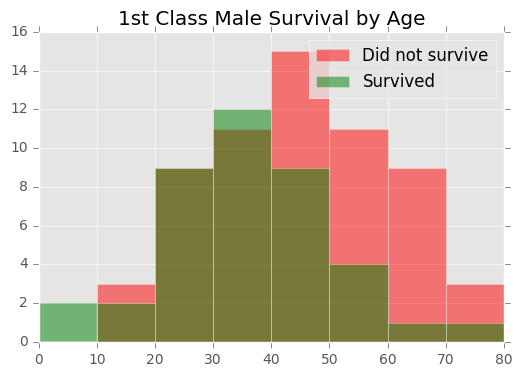

In [8]:
ma=train['Sex']=='male'
c1=train['Pclass']==1
ma_c1_df=train[ma&c1]
age_hist(ma_c1_df, '1st Class Male Survival by Age')

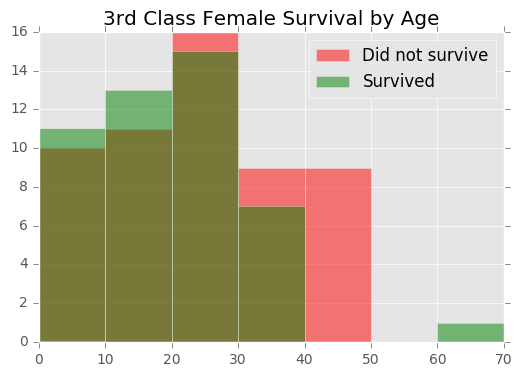

In [9]:
fem=train['Sex']=='female'
c3=train['Pclass']==3
fem_c3_df = train[fem&c3]
age_hist(fem_c3_df, '3rd Class Female Survival by Age')

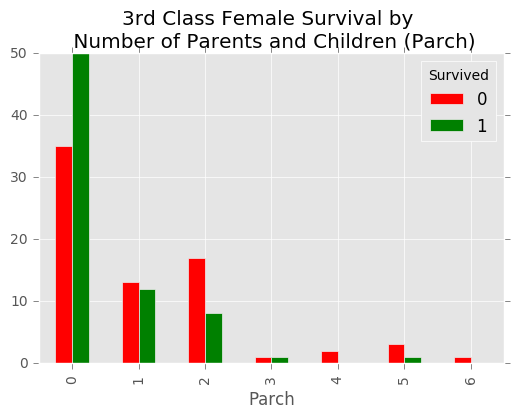

In [10]:
fem_c3_by_parch_df = pd.crosstab(fem_c3_df['Parch'], fem_c3_df['Survived'])
fem_c3_by_parch_df.plot.bar(color = ['r','g'], 
                            title = '3rd Class Female Survival by \n Number of Parents and Children (Parch)')

In [11]:
def manual_tree(data):
    
    predictions = []
    for _, passenger in data.iterrows():
        
        if passenger['Sex']=='female':
            if passenger['Pclass'] ==3:
                if passenger['Age'] > 30 and passenger['Age'] < 60:
                    three = 0
                elif passenger['Parch'] > 1:
                    three = 0
                else:
                    three = 1
            else:
                three = 1
        else:
            if passenger['Age'] < 10:
                three = 1
            elif passenger['Age'] > 30 and passenger['Age'] < 40:
                if passenger['Pclass'] == 1:
                    three = 1
                else:
                    three = 0
            else:
                three = 0

        predictions.append(three)

    return pd.Series(predictions)

In [12]:
y_pred1 = manual_tree(train)
target = train["Survived"].values 

manual_accuracy = accuracy_score(y_pred1, target)

print("Manual accuracy: {:1.3f}".format(manual_accuracy))

Manual accuracy: 0.816


# Feature Engineering

### Define Feature Transformations

In [14]:
def get_surname(df):
    df['surname'] = df["Name"].apply(lambda x: x.split(',')[0].lower())
    return df

def set_title(df):
    df["Title"] = df["Name"].apply(lambda x: re.search(' ([A-Za-z]+)\.',x).group(1))
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 2, "Mme": 3,"Don": 9,"Dona": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}
    df["TitleCat"] = df.loc[:,'Title'].map(title_mapping)
    return df

def set_family_size(df):
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    df["FamilySize"] = pd.cut(df["FamilySize"], bins=[0,1,4,20], labels=[0,1,2])
    return df

def set_name_length(df):
    df["NameLength"] = df["Name"].apply(lambda x: len(x))
    return df
    
def set_embarked(df):
    df["Embarked"] = pd.Categorical.from_array(df.Embarked).codes
    return df
    
def set_fare(df):
    df["Fare"] = df["Fare"].fillna(8.05)
    return df
    
def set_type_cabin(cabin):
    # Use a regular expression to search for a title. 
    cabin_search = re.search('\d+', cabin)
    # If the title exists, extract and return it.
    if cabin_search:
        num = cabin_search.group(0)
        if np.float64(num) % 2 == 0:
            return '2'
        else:
            return '1'
    return '0'

def set_cabin(df):
    df = pd.concat([df,pd.get_dummies(df['Sex'])],axis=1)
    df['CabinCat'] = pd.Categorical.from_array(df.Cabin.fillna('0').apply(lambda x: x[0])).codes
    df["Cabin"] = df["Cabin"].fillna(" ")
    df["CabinType"] = df["Cabin"].apply(set_type_cabin)
    return df

def set_person(passenger,child_age=18):
    age, sex = passenger
    if (age < child_age):
        return 'child'
    elif (sex == 'female'):
        return 'female_adult'
    else:
        return 'male_adult'

def set_childfemale_adultmale(df):
    df = pd.concat([df, pd.DataFrame(df[['Age', 'Sex']].apply(set_person, axis=1), columns=['person'])],axis=1)
    df = pd.concat([df,pd.get_dummies(df['person'])],axis=1)
    return df
    

In [15]:
def set_ticket_features(df):
    table_ticket = pd.DataFrame(df["Ticket"].value_counts())
    table_ticket.rename(columns={'Ticket':'Ticket_Members'}, inplace=True)

    table_ticket['Ticket_perishing_women'] = df.Ticket[(df.female_adult == 1.0) 
                                        & (df.Survived == 0.0) 
                                        & ((df.Parch > 0) | (df.SibSp > 0))].value_counts()
    table_ticket['Ticket_perishing_women'] = table_ticket['Ticket_perishing_women'].fillna(0)
    table_ticket['Ticket_perishing_women'][table_ticket['Ticket_perishing_women'] > 0] = 1.0 

    table_ticket['Ticket_surviving_men'] = df.Ticket[(df.male_adult == 1.0) 
                                        & (df.Survived == 1.0) 
                                        & ((df.Parch > 0) | (df.SibSp > 0))].value_counts()
    table_ticket['Ticket_surviving_men'] = table_ticket['Ticket_surviving_men'].fillna(0)
    table_ticket['Ticket_surviving_men'][table_ticket['Ticket_surviving_men'] > 0] = 1.0 

    table_ticket["Ticket_Id"]= pd.Categorical.from_array(table_ticket.index).codes
    # compress under 3 members into one code.
    table_ticket["Ticket_Id"][table_ticket["Ticket_Members"] < 3 ] = -1
    table_ticket["Ticket_Members"] = pd.cut(table_ticket["Ticket_Members"], bins=[0,1,4,20], labels=[0,1,2])

    df = pd.merge(df, table_ticket, left_on="Ticket",right_index=True,how='left', sort=False)
    return df

In [16]:
def set_surname_features(df):
    table_surname = pd.DataFrame(df["surname"].value_counts())
    table_surname.rename(columns={'surname':'Surname_Members'}, inplace=True)

    table_surname['Surname_perishing_women'] = df.surname[(df.female_adult == 1.0) 
                                        & (df.Survived == 0.0) 
                                        & ((df.Parch > 0) | (df.SibSp > 0))].value_counts()
    table_surname['Surname_perishing_women'] = table_surname['Surname_perishing_women'].fillna(0)
    table_surname['Surname_perishing_women'][table_surname['Surname_perishing_women'] > 0] = 1.0 

    table_surname['Surname_surviving_men'] = df.surname[(df.male_adult == 1.0) 
                                        & (df.Survived == 1.0) 
                                        & ((df.Parch > 0) | (df.SibSp > 0))].value_counts()
    table_surname['Surname_surviving_men'] = table_surname['Surname_surviving_men'].fillna(0)
    table_surname['Surname_surviving_men'][table_surname['Surname_surviving_men'] > 0] = 1.0 

    table_surname["Surname_Id"]= pd.Categorical.from_array(table_surname.index).codes
    # compress under 3 members into one code.
    table_surname["Surname_Id"][table_surname["Surname_Members"] < 3 ] = -1

    table_surname["Surname_Members"] = pd.cut(table_surname["Surname_Members"], bins=[0,1,4,20], labels=[0,1,2])

    df = pd.merge(df, table_surname, left_on="surname",right_index=True,how='left', sort=False)
    
    return df

In [17]:
def set_missing_ages(df):
    classers = ['Fare','Parch','Pclass','SibSp','TitleCat', 
    'CabinCat','female','male', 'Embarked', 'FamilySize', 'NameLength','Ticket_Members','Ticket_Id']
    etr = ExtraTreesRegressor(n_estimators=200)
    X_train = df[classers][df['Age'].notnull()]
    Y_train = df['Age'][df['Age'].notnull()]
    X_test = df[classers][df['Age'].isnull()]
    etr.fit(X_train,np.ravel(Y_train))
    age_preds = etr.predict(X_test)
    df['Age'][df['Age'].isnull()] = age_preds
    return df

In [18]:
def transform_features(df):
    df = get_surname(df)
    df = set_title(df)
    df = set_family_size(df)
    df = set_name_length(df)
    df = set_embarked(df)
    df = set_fare(df)
    df = set_cabin(df)
    df = set_childfemale_adultmale(df)
    df = set_ticket_features(df)
    df = set_surname_features(df)
    df = set_missing_ages(df)
    return df

### Transform dataset

In [19]:
full = pd.concat([train, test])
print(train.shape)
print(test.shape)
print(full.shape)

full_clean = transform_features(full)
print(full_clean.shape)
print(full_clean.columns)

train_clean = full_clean[0:891].copy()
test_clean = full_clean[891:].copy()

(891, 12)
(418, 11)
(1309, 12)


/home/torenunez/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/torenunez/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/torenunez/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(1309, 33)
Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'surname', 'Title',
       'TitleCat', 'FamilySize', 'NameLength', 'female', 'male', 'CabinCat',
       'CabinType', 'person', 'child', 'female_adult', 'male_adult',
       'Ticket_Members', 'Ticket_perishing_women', 'Ticket_surviving_men',
       'Ticket_Id', 'Surname_Members', 'Surname_perishing_women',
       'Surname_surviving_men', 'Surname_Id'],
      dtype='object')


/home/torenunez/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Training the Model

In [20]:
features = ['female','male','Age','male_adult','female_adult', 'child','TitleCat', 'Pclass',
'Pclass','Ticket_Id','NameLength','CabinType','CabinCat', 'SibSp', 'Parch',
'Fare','Embarked','Surname_Members','Ticket_Members','FamilySize',
'Ticket_perishing_women','Ticket_surviving_men',
'Surname_perishing_women','Surname_surviving_men']

In [21]:
cv = cross_validation.KFold(train_clean.shape[0], n_folds=3, random_state=42)
scoring = make_scorer(accuracy_score)
rfc = RandomForestClassifier()

param_grid = {
           'n_estimators': [1600,1800,2000], 
           'min_samples_split': [4,5,6], 
           'class_weight':[{0:0.5,1:0.5},{0:0.6,1:0.4},{0:0.7,1:0.3}]
               }

grid = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring=scoring, cv=cv)

grid.fit(train_clean[features], target)

print(grid.best_estimator_)
print(grid.best_score_)

RandomForestClassifier(bootstrap=True, class_weight={0: 0.5, 1: 0.5},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=1800, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.89898989899


In [22]:
g = grid.best_estimator_
g.fit(train_clean[features], target)
g_accuracy = g.score(train_clean[features], target)
print("Grid Search Random Forest Accuracy: {:1.3f}".format(g_accuracy))

Grid Search Random Forest Accuracy: 0.972


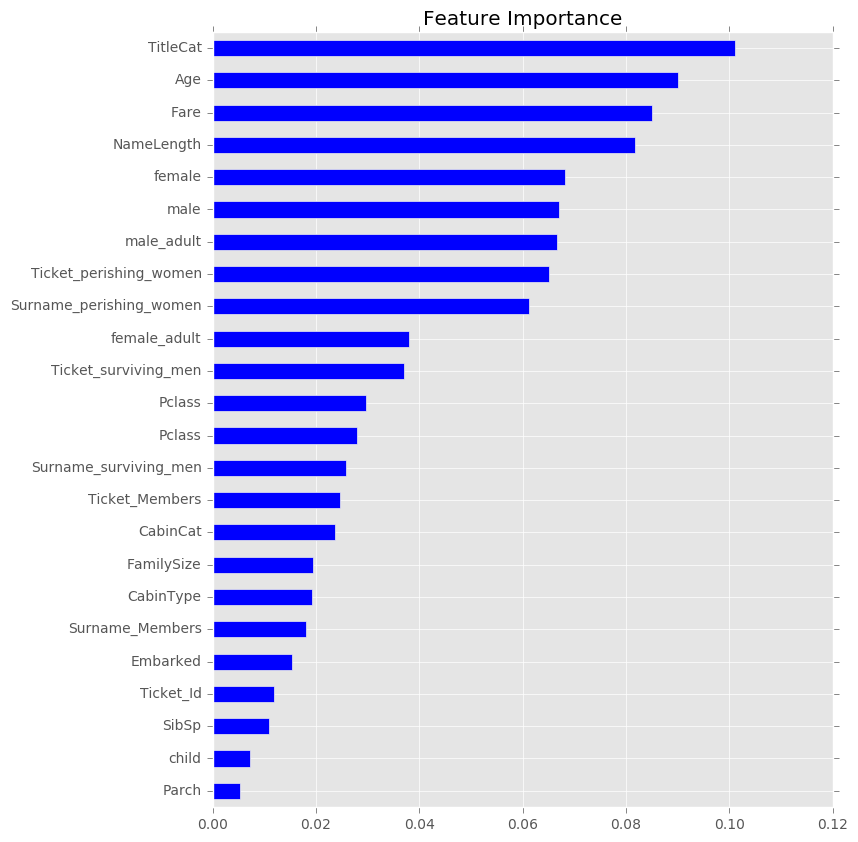

In [23]:
imp = pd.DataFrame( 
    g.feature_importances_  , 
    columns = ['Importance'] , 
    index = train_clean[features].columns 
)
imp = imp.sort_values( [ 'Importance' ] , ascending = True )
imp.plot( kind = 'barh', color = 'b', title = 'Feature Importance', figsize =(8,10), legend=False)

# Generate Prediction

In [24]:
PassengerId =np.array(test_clean["PassengerId"]).astype(int)
predictions = g.predict(test_clean[features])

my_prediction = pd.DataFrame(predictions, PassengerId, columns = ["Survived"])
my_prediction.to_csv("titanic_prediction.csv", index_label = ["PassengerId"])